In [1]:
import csv
from bs4 import BeautifulSoup
import re
import os
import pandas as pd
from lxml import etree
from lxml import html
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
import dateutil
from dateutil.parser import *
from datetime import datetime
import pathlib
from htmldate import find_date
import trafilatura

In [2]:
# process statewise UK VERSION --> type "General"


def process_state_UK(state):

    agile_regex = re.compile(r'\bagility\b|\bagile\b', re.IGNORECASE | re.UNICODE)

    agile_method_regex = re.compile(r'\bagile\b(?:(?![.-]|agile).)*?\bmethod\w*?\b', re.IGNORECASE | re.UNICODE)

    agile_context_regex = re.compile(r'\s*([^\s]+?)\s+([^\s]+?)\s+([^\s]+?)\s+([^\s]+?)\s+agil.*?\s+([^\s]+)\s+([^\s]+?)\s+([^\s]+?)\s+([^\s]+?)\s+', re.IGNORECASE | re.UNICODE)

    digital_regex = re.compile(r'\bdigital\b|\bditialization\b|\bdigitalisation\b\bdigital transformation\b', re.IGNORECASE | re.UNICODE)

    military_regex = re.compile(r'\bmilitary\b|\barmy\b|\barmed forces\b|\bnavy\b|\binfantery\b', re.IGNORECASE | re.UNICODE)

    #searchsite_regex = re.compile(r'search', re.IGNORECASE | re.UNICODE)

    csv_main = csv.DictReader(open("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/1_Data_Collection/DATA/CSVs/UK/SAVEPLACE/agile_sites_output_UK_{}.csv".format(state)), fieldnames=["id", 'url', 'domain', 'date1', 'date2', 'date3', 'heading'])
    array = {}
    for line in csv_main: 
        array[line["id"]] = line
    text_dir = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/TextFiles/UK/{}".format(state)
    pathlib.Path(text_dir).mkdir(parents=True, exist_ok=True)

    for id, line in array.items():
        print("processing {}".format(id))
        id = line["id"]
        domain = line["domain"]
        url = line["url"]
        path = '/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/1_Data_Collection/DATA/HTMLs/UK/SAVEPLACE/{}/{}/{}.html'.format(state, domain, id)
        try:  
            soup = BeautifulSoup(open(path), "html.parser")
        except UnicodeDecodeError:
            soup = BeautifulSoup(open(path, encoding='windows-1252'), "html.parser")    
        

        #Getting date4
        date4_element = soup.select_one("span.date")
        date4 = ""
        if date4_element is not None:
            date4 = date4_element.get_text()
        

        # Getting date6

        date6_element = soup.select_one("h1#page-title + p")
        date6 = ""
        if date6_element is not None:
            date6 = date6_element.get_text()



        #deleting all non-body text content from the html

        for script in soup(['script', 'style', 'a', 'meta', 'head', 'footer', 'navbar', 'header', 'search-box', 'global-cookie-message', 'id="global-cookie-message"', 'global-bar', 'menu', 'noscript', 'global-cookie-message', 'search']):
            script.decompose()    # rip it out
            
        # get text
        doctext = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in doctext.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        doctext = '\n'.join(chunk for chunk in chunks if chunk)
        
        
        #old 'simple' cleaning 
        #doctext = soup.get_text().replace("\n", " ")

        with open("{}/{}.txt".format(text_dir, id), "w") as textfile:
            textfile.write(doctext)
        

        #Getting date5

        htmlparser = etree.HTMLParser()    
        try:
            tree = etree.parse(open(path), htmlparser)
        except UnicodeDecodeError:
            tree = etree.parse(open(path, encoding='windows-1252'), htmlparser)
        
        date5 = tree.xpath("substring(substring-after(/html//script[@type='application/ld+json']/text(), 'datePublished'), 4, 23)")

        # a special cases for date 5
        date5_1 = tree.xpath("substring(substring-after(/html//script[@type='application/ld+json']/text(), 'datePublished'), 4, 25)")


        # Getting date7 from National Archives --> the date the site was archived on --> the date the site was released on would have been even earlier

        date7 = tree.xpath("substring(substring-after(/html/head/script/text(), 'timestamp'),9,14)")

  
        #different parsing for for htmldate and trafilatura

        try:
            html_tree = html.parse(open(path))
        except UnicodeDecodeError:
            html_tree = html.parse(open(path, encoding='windows-1252'))
            

        #Getting date with the htmldate package
        htmldate = find_date(html_tree)

        #since html date gives out nonetype when it doesn't find anything, it has to be respecified to empty string so that it works with dateparser later on
        if htmldate is None:
            htmldate = ''

        #htmldate = htmldate.astype('str')

        #Getting the main content of the page with the trafilatura package
        #main_content = trafilatura.extract(html_tree)


        # assinging the already crawled dates
        date1 = line["date1"]
        date2 = line["date2"]


        # Storing the oldest date as final date variable in python date format
        date_vars = [date1, date2, date4, date5, date5_1, date6, date7, htmldate]
        
        final_date = None 

        for date_var in date_vars:
            try:
                if final_date is None:
                    final_date = parse(date_var, ignoretz = True)
                elif parse(date_var, ignoretz=True) < final_date:
                    final_date = parse(date_var, ignoretz=True)
            except dateutil.parser._parser.ParserError:
                pass 


        #finding the matches for agile and agility
        agile_term = []
        agile_term = agile_regex.findall(doctext.lower())
        

        #finding the matches for agile...methods
        agile_method = []
        agile_method = agile_method_regex.findall(doctext.lower())

         #finding the matches for digital
        digital_term = []
        digital_term = digital_regex.findall(doctext.lower())

        #finding the matches for military
        military_term = []
        military_term  = military_regex.findall(doctext.lower())



        # finding the context for the agile
        agile_context = []
        agile_context = agile_context_regex.search(doctext)

        agile_context_pre = ""
        agile_context_post = ""
        
        if agile_context is not None:
            agile_context_pre = " ".join(agile_context.group(1,2,3,4))
            agile_context_post = " ".join(agile_context.group(5,6,7,8))
        

        # assigning all the variables to the items

        if len(agile_term) == 0:
            line["agile_term"] = "" 
        else:
            line["agile_term"] = ",".join(agile_term)
        
        if len(agile_method) == 0:
            line["agile_method"] = "" 
        else:
            line["agile_method"] = ",".join(agile_method)

        if len(digital_term) == 0:
            line["digital_term"] = "" 
        else:
            line["digital_term"] = ",".join(digital_term)

        if len(military_term) == 0:
            line["military_term"] = "" 
        else:
            line["military_term"] = ",".join(military_term)


        line["agile_context_pre"] = agile_context_pre
        line["agile_context_post"] = agile_context_post 
        line["date4"] = date4
        line["date5"] = date5
        line["date5_1"] = date5_1
        line["date6"] = date6
        line["date7"] = date7
        line["final_date"] = final_date
        line["htmldate"] = htmldate
        line["country"] = "UK"
        line["level"] = state
        #line["main_content"] = main_content
        line["text_file_loc"] = "{}/{}.txt".format(text_dir, id)
        line['doctext'] = doctext
        #line['is_search'] = is_search
        
    outputfile = open("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/{}.csv".format(state), "w")
    writer = csv.DictWriter(outputfile, fieldnames=["id", "country", "level", 'url', 'domain', 'date1', 'date2', 'date3', 'date4', 'date5', 'date5_1', 'date6', 'date7', 'htmldate', 'final_date', 'heading', 'agile_term', 'agile_method', 'agile_context_pre', 'agile_context_post', 'digital_term', 'military_term', 'text_file_loc', 'doctext'])
    writer.writeheader()
    for id, line in array.items():
        writer.writerow(line)
    outputfile.close()
    

In [3]:
#Running processing for UK
process_state_UK("General")

273-11f5-389a-9fdc-bb25698ad02d
processing 129f6cc5-c486-3e87-ba17-f7a9e459cbe7
processing 6623951c-ab58-3e64-946a-711208cb09ab
processing 311bd1b2-fbb8-361c-a0bd-10df02957190
processing 994bb0f2-1762-346a-8458-b2086eaeb744
processing c8e6259e-d532-3be8-b915-64a31a58219d
processing 301dcd04-e8a8-3478-951d-dd1fbcfdbd32
processing 3bd98b3e-6e08-38fd-84a2-312b4e70a36d
processing dae049dc-8dcf-37ca-9746-c5695c348994
processing 10296bf6-9750-30b7-87f9-d616afaff68d
processing 00fbf2a7-1af1-3636-88c6-7d9df0085a8e
processing c1c89022-02b3-3093-8eeb-c1c2408bbbd7
processing d33657af-96f3-3db2-9247-d38a8dc31f2a
processing f953464b-6d01-3672-a78a-6bae348abb79
processing 474df3c9-7253-3377-93d4-d9bdc4972bec
processing fd3373c3-4fd7-32b0-bd98-d8263b7c70f2
processing 6434a58a-6778-33db-9992-7784b5cb9fc4
processing 06321551-224b-30b3-8384-c93cbc7bb417
processing 3546db0c-a883-3a7b-bae3-1beedb3b93e7
processing 15c44474-626e-31e9-ade6-691a38508173
processing 627cc0eb-abbf-3377-aacd-e417f79e3d08
processi

In [32]:
##### Cleaning State UK
#from nltk.tokenize import word_tokenize


inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/General.csv"
outputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/General_v1.csv"

with open(inputFileName, newline='') as inFile, open(outputFileName, 'w', newline='') as outFile:
    df = pd.read_csv(inFile)
    df.sort_values(by=['final_date'])
    df.dropna(axis=0, how='any', thresh=None, subset=(['agile_term']), inplace=True)
    df.drop_duplicates(subset=(['heading', 'agile_context_pre', 'agile_context_post']), inplace=True)
    df['agile_context_pre'] = df['agile_context_pre'].astype(str)
    df['agile_context_post'] = df['agile_context_post'].astype(str)
    df['heading'] = df['heading'].astype(str)
    df['domain'] = df['domain'].astype(str)
    df['doctext'] = df['doctext'].astype(str)
    #deleting search terms
    df = df[~df.url.str.contains('/search/')]
    #deleting false positives
    df = df[~df.agile_context_post.str.startswith("(")] # dropdown menu entry
    df = df[~df.agile_context_pre.str.endswith(")")] # dropdown menu entry
    df = df[~df.agile_context_pre.str.endswith("EB")] # supplier list
    df = df[~df.agile_context_post.str.match('and battle-winning armed forces')] #army related agility
    df = df[~df.agile_context_pre.str.match('Atom CategoriesCategories Select Category')] # dopdown menu entry
    df = df[~df.agile_context_pre.str.match('RAF to Force Generate')] # Entry on Air Commanders
    df = df[~df.agile_context_post.str.startswith("Trains")] # name of a company "Agility Trains"
    df = df[~df.agile_context_post.str.startswith("trains")] # name of a company "Agility Trains"
    df = df[~df.agile_context_post.str.match('People Services Limited Independent')] #company name
    df = df[~df.heading.str.match('Fitness classes')]
    #deleting csv previews
    df = df[~df.domain.str.endswith("csv/preview")]
    #deleting things that have to do with military 
    df = df[df.military_term.isnull()]
    #deleting cases where no date has been found (htmldate attributes 2020-01-01 for no dates)
    df = df[df['final_date'] != '2020-01-01 00:00:00']
    #deleting all cases from 2020 because the year has just started
    df = df[df['final_date'] < '2020-01-01 00:00:00']
    df['final_date'] = pd.to_datetime(df['final_date'])
    #df['tokens'] = df['doctext'].apply(word_tokenize)
    df.to_csv(outFile)

In [6]:
##### Adding Organisation Names based on domain
inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/General_v1.csv"
outputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/General_v2.csv"
domains_dict = pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/List_of_gov.uk_domain_names_as_at_28_Oct_2019.csv")

domain_regex = re.compile(r'http(s?)://(?!.*http)(www\.)?([a-zA-Z0-9\-.]+)', re.IGNORECASE | re.UNICODE)

def extract(url):
    match = domain_regex.search(url)
    if match:
        match_domain = match.group(3)
        return '.'.join(match_domain.split('.')[-3:])
    else:
        print(url)
        return ''

with open(inputFileName, newline='') as inFile, open(outputFileName, 'w', newline='') as outFile:
    df = pd.read_csv(inFile)
    df['domain_mod'] = df.apply(lambda row: extract(row['url']), axis=1)
    df2 = pd.merge(df, domains_dict, left_on = 'domain_mod', right_on='Domain: Domain Name', how='left')

    df2.to_csv(outFile)
df2

,Unnamed: 0,id,country,level,url,domain,date1,date2,date3,date4,...,agile_context_pre,agile_context_post,digital_term,military_term,text_file_loc,doctext,domain_mod,Domain: Domain Name,Organisation,Registered for
0,3,48f7ab58-cabb-3461-9dcd-0ad29d6fae28,UK,General,https://www.gov.uk/guidance/accessibility-requ...,www.gov.uk,2019-05-17T15:40:09.000+01:00,NaN,NaN,NaN,...,If you’re using an,approach to redeveloping an,digital,NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,Tell us whether you accept cookies\nWe use\nab...,gov.uk,gov.uk,General Domain,General Domain
1,6,ecb03a68-22dc-36a4-b0c9-e5e1a123a0bd,UK,General,https://www.gov.uk/guidance/guidance-for-opera...,www.gov.uk,2016-02-15T11:32:40.000+00:00,NaN,NaN,NaN,...,"of government, has increased",to address the regulatory,NaN,NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,Tell us whether you accept cookies\nWe use\nab...,gov.uk,gov.uk,General Domain,General Domain
2,10,6ddf8e67-c2c5-3901-b212-6aeb67417d5f,UK,General,https://www.gov.uk/government/publications/civ...,www.gov.uk,NaN,NaN,NaN,NaN,...,"a responsive, resilient, and",social sector. The government,"digital,digital,digital,digital,digital,digita...",NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,Tell us whether you accept cookies\nWe use\nab...,gov.uk,gov.uk,General Domain,General Domain
3,12,10be72cd-dcf9-376d-8f86-9b9d7a60e0f4,UK,General,https://www.gov.uk/government/speeches/eureka-...,www.gov.uk,NaN,NaN,NaN,NaN,...,and to provide an,platform that can adapt,NaN,NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,Tell us whether you accept cookies\nWe use\nab...,gov.uk,gov.uk,General Domain,General Domain
4,13,9494ba7d-bc3e-328f-b123-87574faaaa94,UK,General,https://www.gov.uk/government/speeches/the-uk-...,www.gov.uk,NaN,NaN,NaN,NaN,...,why we need an,and responsive regulatory approach.,NaN,NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,Tell us whether you accept cookies\nWe use\nab...,gov.uk,gov.uk,General Domain,General Domain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2374,c2684060-e94d-3f3a-8437-cd013eaa030b,UK,General,https://gds.blog.gov.uk/2014/10/15/building-di...,gds.blog.gov.uk,2014-10-15T12:00:00+01:00,NaN,NaN,NaN,...,about working in an,way. You can adjust,"digital,digital,digital,digital,digital,digita...",NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,GOV.UK blogs use cookies to make the site simp...,blog.gov.uk,blog.gov.uk,Cabinet Office,gov.uk blogging platform
620,2376,ebefeb60-844f-3c4f-bc35-9380fb5286fb,UK,General,https://digitalpeople.blog.gov.uk/2017/03/08/d...,digitalpeople.blog.gov.uk,2017-03-08T16:26:53+00:00,NaN,NaN,NaN,...,is very un-corporate and,which I like. Registers,"digital,digital,digital,digital,digital,digita...",NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,GOV.UK blogs use cookies to make the site simp...,blog.gov.uk,blog.gov.uk,Cabinet Office,gov.uk blogging platform
621,2379,b1bacb13-a7e0-34f8-9bf9-2e4202c511cc,UK,General,https://gds.blog.gov.uk/2013/07/18/transformin...,gds.blog.gov.uk,2013-07-18T09:30:47+01:00,NaN,NaN,NaN,...,"ways of working, developing",skills and transforming how,"digital,digital,digital,digital,digital,digita...",NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,GOV.UK blogs use cookies to make the site simp...,blog.gov.uk,blog.gov.uk,Cabinet Office,gov.uk blogging platform
622,2380,4b00f33c-876b-3d78-9dcc-97b98a3e1c2d,UK,General,https://gds.blog.gov.uk/2012/12/13/meet-the-tr...,gds.blog.gov.uk,2012-12-13T11:37:13+00:00,NaN,NaN,NaN,...,also favour smaller organisations.,in action - Student,"digital,digital,digital,digital,digital,digita...",NaN,/Users/mxm/Google Drive/Masterstudium/Inhalte/...,GOV.UK blogs use cookies to make the site simp...,blog.gov.uk,blog.gov.uk,Cabinet Office,gov.uk blogging platform


In [ ]:
# Testing for Visualisation

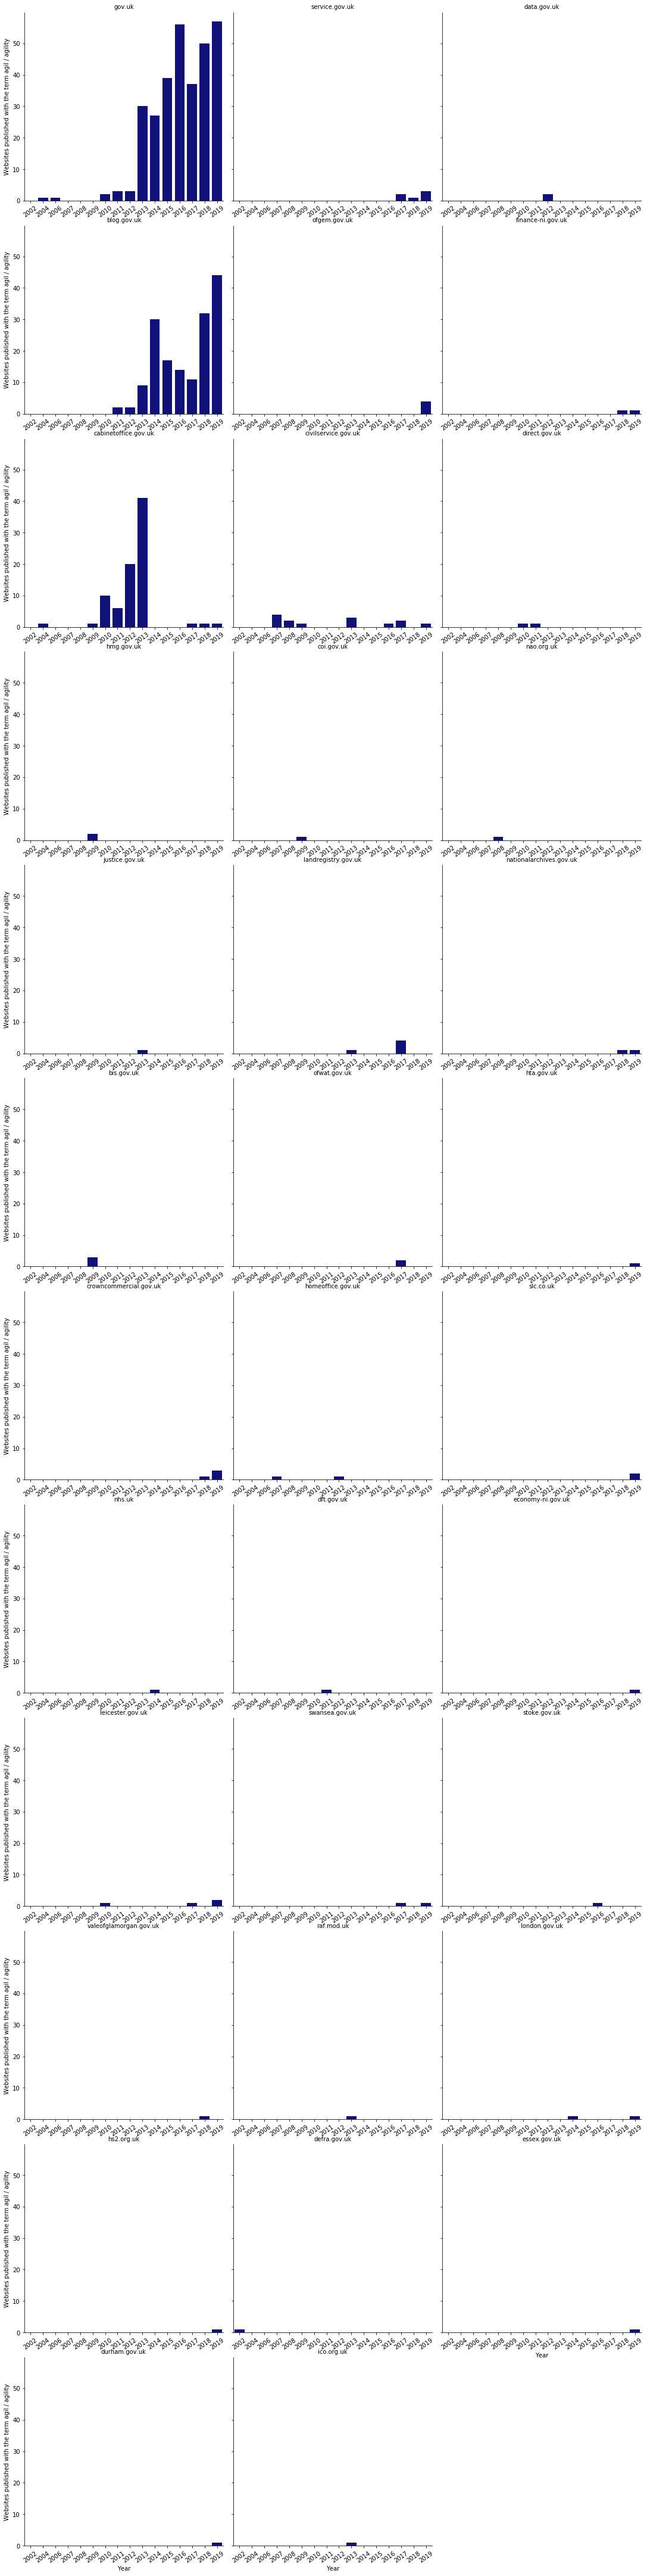

In [21]:
#Plotting
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/General_v2.csv"
df=pd.read_csv(inputFileName, parse_dates=["final_date"])
df['Year'] = df['final_date'].dt.year
df2 = df.groupby(["Year"]).count()
df2.reset_index(inplace=True)
# g = sns.FacetGrid(df,col="Organisation", col_wrap=3)
# g.map(sns.factorplot,'Year')
plot = sns.catplot(x='Year', kind='count', data=df, col='domain_mod', col_wrap=3, sharex=False, sharey=True, color='darkblue')
plot.set_xticklabels(rotation=35)
plot.set_ylabels(label="Websites published with the term agil / agility")
plot.set_titles("{col_name}")

In [ ]:
##############GERMANY##################

In [4]:
# process statewise GERMAN VERSION 

def process_state_DE(state):


    agile_regex = re.compile(r'\bagility\b|\bagil\w{0,2}\b|\bagilität\b', re.IGNORECASE | re.UNICODE)

    agile_method_regex = re.compile(r'\bagil\w{0,2}\b(?:(?![.,:-;!?]|agil\w{0,2}).)*?\b\w*?method\w*?\b', re.IGNORECASE | re.UNICODE)

    agile_context_regex = re.compile(r'\s*([^\s]+?)\s+([^\s]+?)\s+([^\s]+?)\s+([^\s]+?)\s+agil.*?\s+([^\s]+)\s+([^\s]+?)\s+([^\s]+?)\s+([^\s]+?)\s+', re.IGNORECASE | re.UNICODE)
    
    digital_regex = re.compile(r'\bdigital\w{0,2}\b|\bdigitalisierung\b|\bdigitale transformation\b', re.IGNORECASE | re.UNICODE)

    csv_main = csv.DictReader(open("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/1_Data_Collection/DATA/CSVs/Germany/agile_sites_output_Germany_{}.csv".format(state)), fieldnames=["id", 'url', 'domain', 'date1', 'date2', 'date3', 'heading'])
    array = {}


    for line in csv_main: 
        array[line["id"]] = line
    text_dir = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/TextFiles/Germany/{}".format(state)
    pathlib.Path(text_dir).mkdir(parents=True, exist_ok=True)

    for id, line in array.items():
        print("processing {}".format(id))
        id = line["id"]
        domain = line["domain"]
        #excluding hits from berlin jobs
        if domain == 'jobs.berlin.de':
            continue

        url = line["url"]
        path = '/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/1_Data_Collection/DATA/HTMLs/Germany/{}/{}/{}.html'.format(state, domain, id)
        try:  
            soup = BeautifulSoup(open(path), "html.parser")
        except UnicodeDecodeError:
            soup = BeautifulSoup(open(path, encoding='windows-1252'), "html.parser")    
        

        #Getting date4
        date4_element = soup.select_one("span.date")
        date4 = ""
        if date4_element is not None:
            date4 = date4_element.get_text()
        

        # Getting date6

        date6_element = soup.select_one("h1#page-title + p")
        date6 = ""
        if date6_element is not None:
            date6 = date6_element.get_text()



        #deleting all non-body text content from the html

        for script in soup(['script', 'style', 'a', 'meta', 'head', 'footer', 'navbar', 'header', 'search-box', 'global-cookie-message', 'id="global-cookie-message"', 'global-bar', 'menu', 'noscript', 'global-cookie-message', 'search']):
            script.decompose()    # rip it out
            
        # get text
        doctext = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in doctext.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        doctext = '\n'.join(chunk for chunk in chunks if chunk)
        
        
        #old 'simple' cleaning 
        #doctext = soup.get_text().replace("\n", " ")

        with open("{}/{}.txt".format(text_dir, id), "w") as textfile:
            textfile.write(doctext)
        

        #Getting date5

        htmlparser = etree.HTMLParser()    
        try:
            tree = etree.parse(open(path), htmlparser)
        except UnicodeDecodeError:
            tree = etree.parse(open(path, encoding='windows-1252'), htmlparser)
        
        date5 = tree.xpath("substring(substring-after(/html//script[@type='application/ld+json']/text(), 'datePublished'), 4, 24)")


        # Getting date7 from National Archives --> the date the site was archived on --> the date the site was released on would have been even earlier

        date7 = tree.xpath("substring(substring-after(/html/head/script/text(), 'timestamp'),9,14)")

  
        #different parsing for for htmldate and trafilatura

        try:
            html_tree = html.parse(open(path))
        except UnicodeDecodeError:
            html_tree = html.parse(open(path, encoding='windows-1252'))
            

        #Getting date with the htmldate package
        htmldate = find_date(html_tree)

        #since html date gives out nonetype when it doesn't find anything, it has to be respecified to empty string so that it works with dateparser later on
        if htmldate is None:
            htmldate = ''


        # assinging the already crawled dates
        date1 = line["date1"]
        date2 = line["date2"]


        # Storing the oldest date as final date variable in python date format
        date_vars = [date1, date2, date4, date5, date6, date7, htmldate]
        
        final_date = None 

        for date_var in date_vars:
            try:
                if final_date is None:
                    final_date = parse(date_var, ignoretz = True)
                elif parse(date_var, ignoretz=True) < final_date:
                    final_date = parse(date_var, ignoretz=True)
            except dateutil.parser._parser.ParserError:
                pass 


        #finding the matches for agile and agility
        agile_term = []
        agile_term = agile_regex.findall(doctext.lower())
        

        #finding the matches for agile...methods
        agile_method = []
        agile_method = agile_method_regex.findall(doctext.lower())

         #finding the matches for digital
        digital_term = []
        digital_term = digital_regex.findall(doctext.lower())


        # finding the context for the agile
        agile_context = []
        agile_context = agile_context_regex.search(doctext)

        agile_context_pre = ""
        agile_context_post = ""
        
        if agile_context is not None:
            agile_context_pre = " ".join(agile_context.group(1,2,3,4))
            agile_context_post = " ".join(agile_context.group(5,6,7,8))
        

        # assigning all the variables to the items

        if len(agile_term) == 0:
            line["agile_term"] = "" 
        else:
            line["agile_term"] = ",".join(agile_term)
        
        if len(agile_method) == 0:
            line["agile_method"] = "" 
        else:
            line["agile_method"] = ",".join(agile_method)

        if len(digital_term) == 0:
            line["digital_term"] = "" 
        else:
            line["digital_term"] = ",".join(digital_term)


        line["agile_context_pre"] = agile_context_pre
        line["agile_context_post"] = agile_context_post 
        line["date4"] = date4
        line["date5"] = date5
        line["date6"] = date6
        line["date7"] = date7
        line["final_date"] = final_date
        line["htmldate"] = htmldate
        line["country"] = "Germany"
        line["level"] = state
        line["text_file_loc"] = "{}/{}.txt".format(text_dir, id)
        line['doctext'] = doctext

        
    outputfile = open("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/{}.csv".format(state), "w")
    writer = csv.DictWriter(outputfile, fieldnames=["id", "country", "level", 'url', 'domain', 'date1', 'date2', 'date3', 'date4', 'date5', 'date6', 'date7', 'htmldate', 'final_date', 'heading', 'agile_term', 'agile_method', 'agile_context_pre', 'agile_context_post', 'digital_term', 'text_file_loc', 'doctext'])
    writer.writeheader()
    for id, line in array.items():
        writer.writerow(line)
    outputfile.close()

In [5]:
#######Processing Statewise Germany
state_list = ["Federal", "Schleswig-Holstein","Bremen","Hamburg","Lower Saxony","Thuringia","Saxony-Anhalt","Saxony","Mecklenburg-Vorpommern","Berlin","Brandenburg","North Rhine-Westphalia","Rhineland-Palatinate","Saarland"
#,"Hesse"
#,"Bavaria"
#,"Baden-Wuerttemberg"
]

for state in state_list:
    print('processing ', state)
    process_state_DE(state)


-5477262e7c9f
processing 3207e30e-a876-36ad-9378-d1a140febbf3
processing a721368c-2e03-3c52-ad7c-241eec2bbd38
processing 9b2366a8-0b41-3445-8cd9-3eb3c2f807ab
processing 332cae26-9a20-34c8-aaa1-08bceb8f157f
processing 17f14fc0-d630-33c0-b155-3a44158dc0e8
processing a827f6b4-e983-3373-9e93-229f1a4672f5
processing e0ca2dc2-ed28-3acb-be47-2e9653e15fb4
processing ecd1a677-1864-31bf-9d9b-971c2bcfab5f
processing cbc6d383-e496-38ee-bac7-2889b15a3f1f
processing df1d1421-c312-3a6d-bce8-01d299f142e6
processing 3a035fb8-d4e1-3c99-9b80-3b544db78b6e
processing 26fdcd4c-e083-311a-845f-987bf228e5ef
processing e1aa02d6-f5aa-3c34-ae39-264439de1d58
processing aec254d8-4f9f-3d5e-b47c-c03b00f97e06
processing e758701e-ddd7-3e5e-9268-d44143725b90
processing ab7f7e83-4480-3548-a632-6ec38f7e9a4c
processing fcb370f3-e192-317f-9089-20067920a15f
processing 1719f758-192a-330e-b117-f1fffdfb31c7
processing 7f143029-56c8-3124-a46f-41dd032160d8
processing 19df8084-ef46-3999-adbc-3bbcf11870ec
processing 6924ae2c-0f93-3

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/1_Data_Collection/DATA/CSVs/Germany/agile_sites_output_Germany_Hesse.csv'

In [9]:
#####Merging all German States
state_list = ["Federal", "Schleswig-Holstein","Bremen","Hamburg","Lower Saxony","Thuringia","Saxony-Anhalt","Saxony","Mecklenburg-Vorpommern","Berlin","Brandenburg","North Rhine-Westphalia","Rhineland-Palatinate","Saarland"
#,"Hesse"
#,"Bavaria"
#,"Baden-Wuerttemberg"
]

state_df = {}

def reading_csv(state):
    inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/{}.csv".format(state)
    outputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/{}_v1.csv".format(state)
    with open(inputFileName, newline='') as inFile, open(outputFileName, 'w', newline='') as outFile:
        df = pd.read_csv(inFile)
    return df

combined_dataframe_Germany = None 

for state in state_list:
    temp_df = reading_csv(state)
    if combined_dataframe_Germany is None:
       combined_dataframe_Germany = temp_df

    else: 
        combined_dataframe_Germany = pd.concat([combined_dataframe_Germany,temp_df])
    combined_dataframe_Germany.to_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/Combined.csv")

In [25]:
##### Cleaning Combined Dataframe Germany

inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/Combined.csv"
outputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/Combined_v1.csv"

with open(inputFileName, newline='') as inFile, open(outputFileName, 'w', newline='') as outFile:
    df = pd.read_csv(inFile)
    df.sort_values(by=['final_date'])
    df.dropna(axis=0, how='any', thresh=None, subset=(['agile_term']), inplace=True)
    df.drop_duplicates(subset=(['heading', 'agile_context_pre', 'agile_context_post']), inplace=True)
    df['agile_context_pre'] = df['agile_context_pre'].astype(str)
    df['agile_context_post'] = df['agile_context_post'].astype(str)
    df['heading'] = df['heading'].astype(str)
    df['domain'] = df['domain'].astype(str)
    df['doctext'] = df['doctext'].astype(str)
    df['htmldate'] = df['htmldate'].astype(str)
    df = df[~df.url.str.contains('/search/')] # deleting search sites
    df = df[~df.agile_term.str.contains('agilis')]
    df = df[~df.domain.str.endswith("csv/preview")]   #deleting csv previews
    df = df[~df.url.str.contains('/tickets/')] # deleting ticket counts
    df = df[~df.htmldate.str.contains('1999-01-01')] # deleting content where date has been wrongly classified and true date is none-attainable
    df = df[~df.url.str.contains('https://www.archaeologie.sachsen.de/3383.htm')] # deleting content related to archeological search
    df = df[~df.doctext.str.contains('Ambitioniert und agil')] # deleting content related to a search named ambitioniert und agil
    df = df[~df.doctext.str.contains('Athlet')] # deleting content related to agile Athletes
    df = df[~df.agile_context_post.str.contains('fröhliche Tiere präsentieren zu')] # deleting infos on zoo visits
    df = df[~df.agile_context_post.str.contains('of a helicopter when')] # deleting the agility of a helicopter
    df = df[~df.agile_context_post.str.contains('Alassane Plea traf Gladbachs')] # deleting an agile football player
    df = df[~df.url.str.contains('ampelmaennchen')] # deleting the agile ampelmännchen
    df = df[~df.agile_context_post.str.contains('Research Platform for the')] #Research Platform for the
    df = df[~df.url.str.contains('/FR/')] # deleting non-german content
    df = df[~df.url.str.contains('/fr/')] # deleting non-german content
    df = df[~df.url.str.contains( '/EN/'  )] # deleting non-german content
    df = df[~df.url.str.contains('/en/' )] # deleting non-german content
    df = df[~df.url.str.contains('/breg-en/' )] # deleting non-german content
    df = df[~df.url.str.contains('/breg-fr/' )] # deleting non-german content
    df = df[~df.url.str.contains('urlaub-mit-hund')] # deleting dog related content
    df = df[~df.doctext.str.contains('Rentner')] # deleting content related to agile senior citizens
    df = df[~df.doctext.str.contains('Senior')] # deleting content related to agile senior citizens
    df = df[~df.doctext.str.contains('Agil im Alter')] # deleting content related to senior citizens
    df = df[~df.doctext.str.contains('Mediation sowie die Moderation')] # deleting content related to dog sport
    df = df[~df.doctext.str.contains('Hundesport')] # deleting content related to dog sport
    df = df[~df.doctext.str.contains('Hund ')] # deleting content related to dog sport
    df = df[~df.doctext.str.contains('Lexus')] # deleting content related to cars
    df = df[~df.doctext.str.contains('Lexus')] # deleting content related to cars
    df = df[~df.doctext.str.contains('Pedelec')] # deleting content related to Pedelecs
    df = df[~df.doctext.str.contains('factory of the future.')] # deleting content related to car manufacturing
    df = df[~df.doctext.str.contains('„Forschung Agil“')] # deleting content related to the Forschungsschwerpunkt Forschung Agil
    df = df[~df.domain.str.contains('search.sachsen.de')] # deleting search results for sachsen
    df = df[~df.domain.str.contains('marketing.hamburg.de')] # deleting content from marketing hamburg
    df = df[~df.domain.str.contains('www.auswaertiges-amt.de')] # deleting content from marketing hamburg
    #deleting cases where no date has been found (htmldate attributes 2020-01-01 for no dates)
    df = df[df['final_date'] != '2020-01-01 00:00:00']
    #deleting all cases from 2020 because the year has just started
    df = df[df['final_date'] < '2020-01-01 00:00:00']
    df['final_date'] = pd.to_datetime(df['final_date'])
    #df['tokens'] = df['doctext'].apply(word_tokenize)
    df.to_csv(outFile)

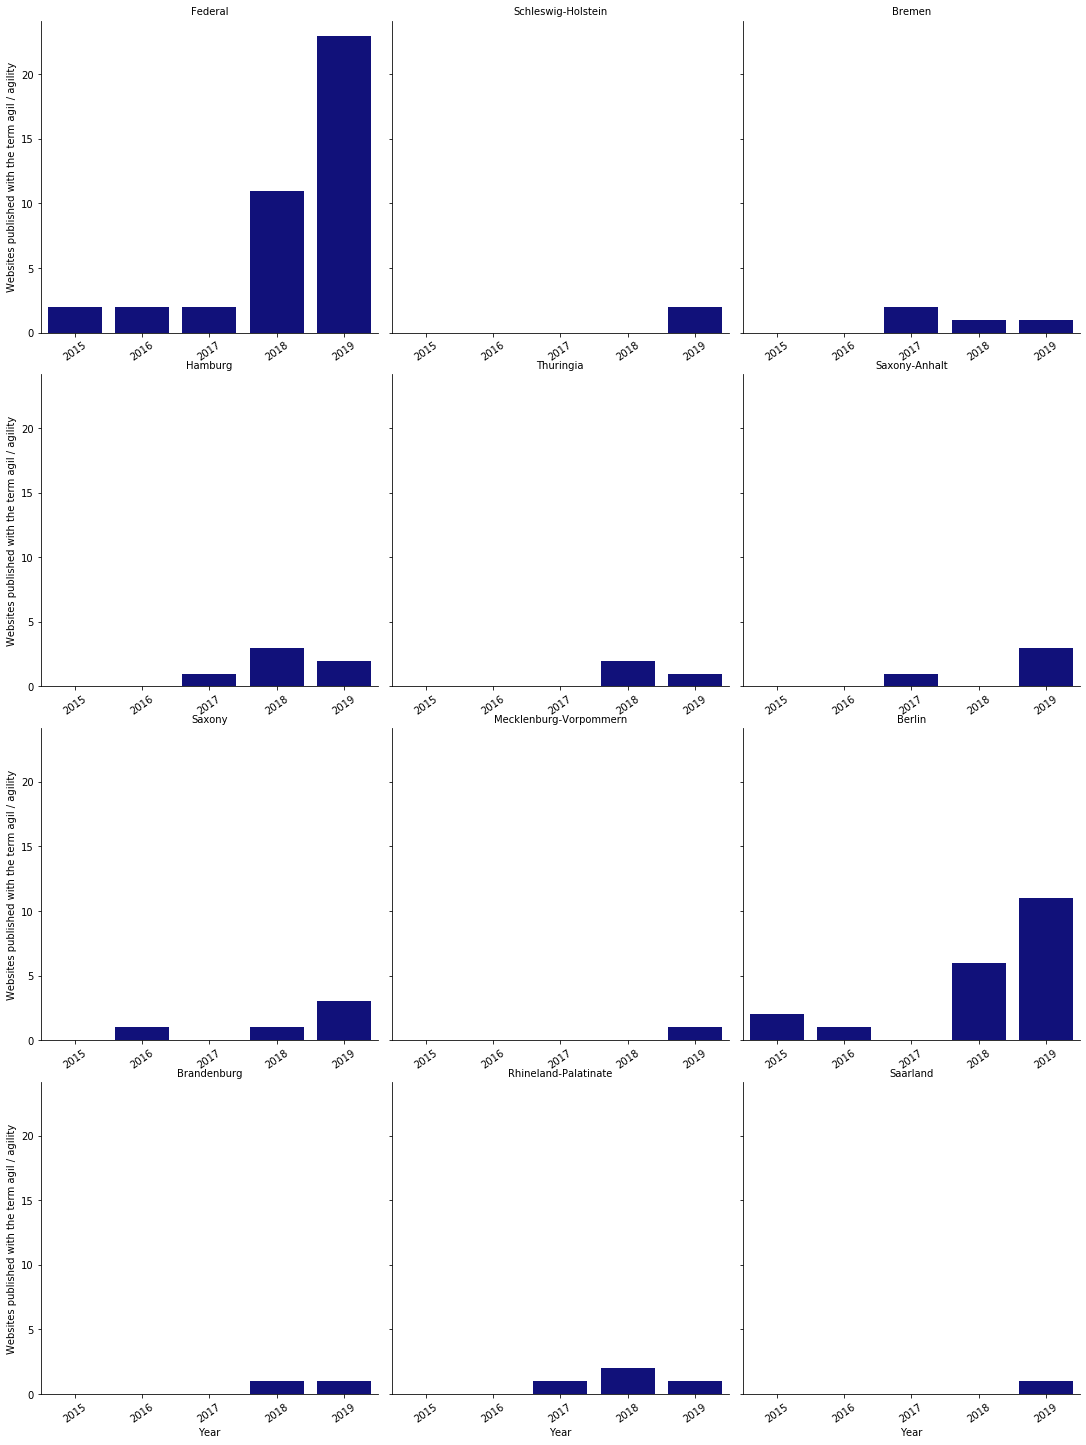

In [26]:
#Plotting per State Germany
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/Combined_v1.csv"
df=pd.read_csv(inputFileName, parse_dates=["final_date"])
df['Year'] = df['final_date'].dt.year
df2 = df.groupby(["Year"]).count()
df2.reset_index(inplace=True)
plot = sns.catplot(x='Year', kind='count', data=df, col='level', col_wrap=3, sharex=False, sharey=True, color='darkblue')
plot.set_xticklabels(rotation=35)
plot.set_ylabels(label="Websites published with the term agil*")
plot.set_titles("{col_name}")

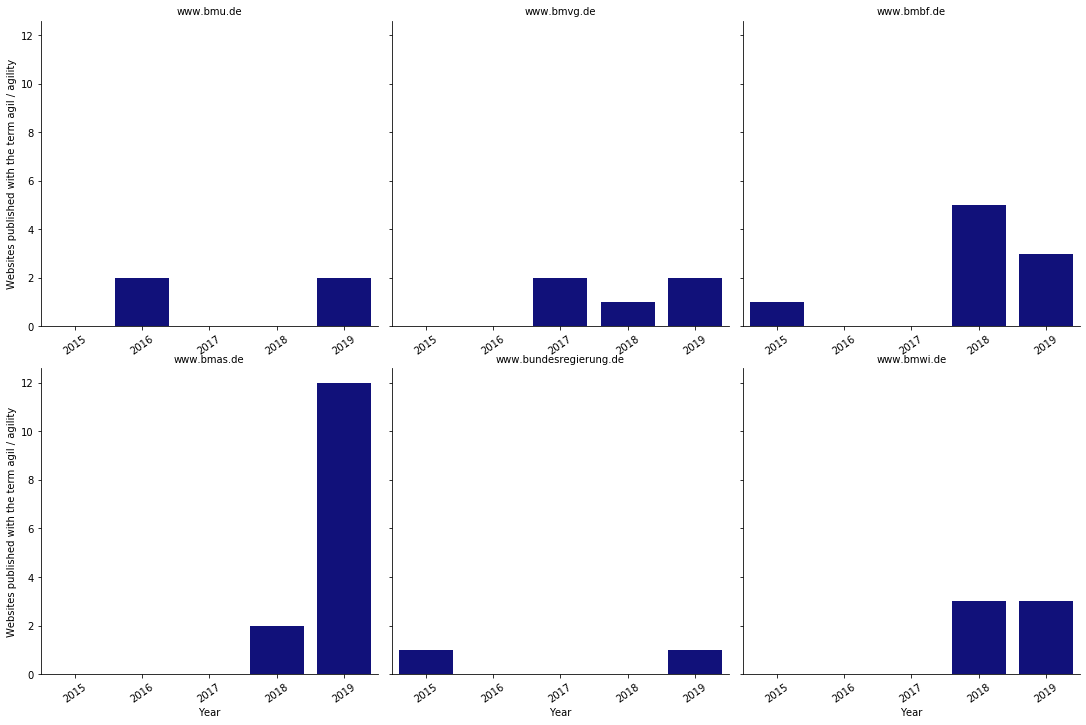

In [27]:
#Printing only Federal Level Ministries
inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/Combined_v1.csv"
df=pd.read_csv(inputFileName, parse_dates=["final_date"])
df = df[df['level'] == 'Federal']
df['Year'] = df['final_date'].dt.year
df2 = df.groupby(["Year"]).count()
df2.reset_index(inplace=True)
plot = sns.catplot(x='Year', kind='count', data=df, col='domain', col_wrap=3, sharex=False, sharey=True, color='darkblue')
plot.set_xticklabels(rotation=35)
plot.set_ylabels(label="Websites published with the term agil*")
plot.set_titles("{col_name}")

In [17]:
####### Combining all the Data Frames into one with pandas ########

df_germany =  pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Germany/Combined_v1.csv")
df_uk = pd.read_csv('/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/UK/General_v2.csv')
df_master = pd.concat([df_germany,df_uk])

df_master.to_csv('/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Master_File.csv')



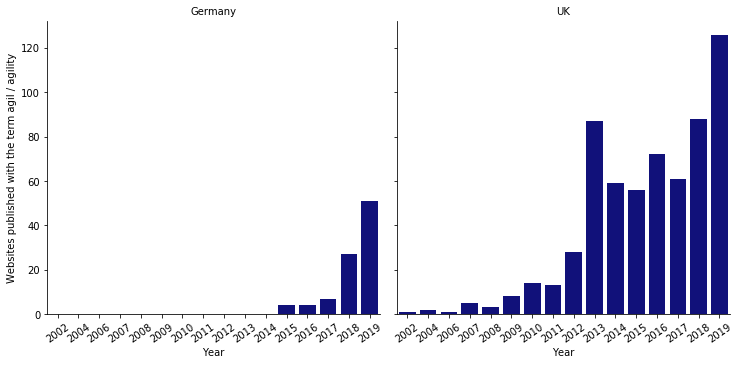

In [20]:
###### Comparing UK and Germany
inputFileName = "/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GitHubRepo/agile-in-government/Analysis/2_Data_Preprocessing/DATA/CSVs/Master_File.csv"
df=pd.read_csv(inputFileName, parse_dates=["final_date"])
df['Year'] = df['final_date'].dt.year
df2 = df.groupby(["Year"]).count()
df2.reset_index(inplace=True)
plot = sns.catplot(x='Year', kind='count', data=df, col='country', col_wrap=3, sharex=False, sharey=True, color='darkblue')
plot.set_xticklabels(rotation=35)
plot.set_ylabels(label="Websites published with the term agil*")
plot.set_titles("{col_name}")



In [ ]:
################### END OF PREPROCESSING ###################

In [28]:
#tester for getting dates with Xpath

htmlparser = etree.HTMLParser()    
try:
    tree = etree.parse(open("/Users/mxm/Google Drive/Masterstudium/Inhalte/Master Thesis/GithubRepository/Analysis/ALL_CRAWLS/Germany/Federal/www.westmidlands-pcc.gov.uk/765598f5-dc1c-3af2-94a6-96bd59ad0c44.html", "r"), htmlparser)
except UnicodeDecodeError:
    tree = etree.parse(open(path, encoding='windows-1252'), htmlparser)
date8 = tree.xpath("substring(substring-after(/html//script[@type='application/ld+json']/text(), 'datePublished'), 4, 25)")
print(date8)



2019-05-29T12:44:02+00:00


In [62]:
#testing regex expressions

agile_method_regex = re.compile(r'\bagil\w{0,2}\b(?:(?![.]|agil\w{0,2}).)*?\b\w*?method\w*?\b', re.IGNORECASE | re.UNICODE)
doctext = 'Die Entwicklung fand unter Nutzung agiler Managementmethoden und einer sehr engen Zusammenarbeit mit zivilen Firmen statt. Diese Form des Projektmanagements ist innerhalb der Streitkräfte bislang einmalig. Innerhalb von insgesamt nur zehn Monaten sind so ein ITInformationstechnik-System, ein Gebäude und ein Team entstanden, das eine Lage führen kann, die es bisher nicht gab. and agile methods are'

#finding the matches for agile...methods
agile_method = []
agile_method = agile_method_regex.findall(doctext.lower())

if len(agile_method) == 0:
    agile_method = "" 
else:
    agile_method = ",".join(agile_method)

print(agile_method)

agiler managementmethoden,agile methods


In [4]:
#testing deletion of elements from HTML

markup = '<li class="gem-c-related-navigation__link"><a class="gem-c-related-navigation__section-link gem-c-related-navigation__section-link--sidebar  gem-c-related-navigation__section-link--other" data-track-category="relatedLinkClicked" data-track-action="1.4 Related content" data-track-label="/government/publications/assurance-for-agile-delivery-of-digital-services" href="/government/publications/assurance-for-agile-delivery-of-digital-services">Assurance for agile delivery of digital services</a></li>'
soup = BeautifulSoup(markup)
a_tag = soup.a

soup.i.decompose()

a_tag
# <a href="http://example.com/">I linked to</a>

AttributeError: 'NoneType' object has no attribute 'items'